In [1]:
pip install botorch torch gpytorch scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.6/629.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl 

In [2]:
import numpy as np
import pandas as pd
import torch
from botorch.models import FixedNoiseGP, SingleTaskGP, HeteroskedasticSingleTaskGP
from gpytorch.kernels import ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from scipy.stats import norm
from botorch.acquisition.analytic import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound, PosteriorMean
import matplotlib.pyplot as plt
import sys
import time
import os
from torch.optim import Adam
import gpytorch
import seaborn as sns

In [3]:
data=pd.read_csv('MOF_data.csv')

In [4]:
# Randomize the rows
#data_new = data.sample(frac=1).reset_index(drop=True)
data_new = data.sample(frac=1, random_state=42).reset_index(drop=True)
#data=data_new
# Save the randomized DataFrame to an Excel file
#data_new.to_excel('randomized_data.xlsx', index=False)

In [26]:

# Identify rows with any NaN values
rows_with_nan = data.isnull().any(axis=1)

# Display rows that contain NaN values
print("\nRows with NaN values:")
print(data[rows_with_nan])

# Remove rows with any NaN values
df = data.dropna()
df = df[df['del_q'] >= 0]
df=df.drop('Pu',axis=1).reset_index(drop=True) #It contains all values as 0
print("\nDataFrame after removing rows with NaN values:")
print(df)


Rows with NaN values:
                                               MOF  uptake_ads  uptake_des  \
7181  acs.inorgchem.6b00276_ic6b00276_si_006_clean    0.421515    0.395023   
7182  acs.inorgchem.6b01762_ic6b01762_si_002_clean    0.087637    0.074696   
7183  acs.inorgchem.6b02696_ic6b02696_si_002_clean    0.294982    0.280449   
7184              acscombsci.5b00188_5036495_clean    0.549701    0.613880   

         del_q  heat_ads  heat_des  del_H_ads      LISD     LFSD     LISFS  \
7181  0.026492 -39.33925       NaN        NaN  14.12459  8.71298  14.12459   
7182  0.012940 -30.35526       NaN        NaN  11.40609  8.52606  11.40609   
7183  0.014533 -34.78612       NaN        NaN  12.11622  5.03656  12.11622   
7184 -0.064179 -18.93596       NaN        NaN  11.02841  8.71025  10.83963   

      ...  La  Cr  Ti  Ba  Rh  Ce  Cu  Al  Re       COP  
7181  ...   0   0   0   0   0   0   0   0   0  0.216845  
7182  ...   0   0   0   0   0   0   0   0   0  0.105920  
7183  ...   0   0   0

In [27]:
X=df.iloc[:,7:-1]
Y=df.iloc[:,-1]
#material_names=df.iloc[:,0]

In [28]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [29]:
X_npArray=X.to_numpy()
Y_npArray=Y.to_numpy()

In [30]:
# Initialize BO parameters
nb_iterations = 110
nb_runs = 10
initial_mofs = 10  # Number of initial MOFs to randomly select

In [31]:
# Convert to torch tensors
X_tensor = torch.from_numpy(X_npArray).float()
y_tensor = torch.from_numpy(Y_npArray).float()
# Placeholder for acquired MOFs
acquired_mofs = []

# Select initial MOFs randomly
initial_ids = np.random.choice(np.arange(len(X)), size=initial_mofs, replace=False)
#initial_ids = np.random.choice(np.arange(1,100), size=initial_mofs, replace=False),
'''if taken random from only initial mofs, properties of last mofs are not being able to be predicted properly'''
acquired_mofs.extend(initial_ids)

X_unsqueezed = X_tensor.unsqueeze(1)

#features=df.columns[7:-1]

In [32]:
# Min-max scaling for X_train
scaler_X = StandardScaler()
scaler=MinMaxScaler()
X_tensor = torch.tensor(scaler_X.fit_transform(X_tensor), dtype=torch.float64)
X_tensor=torch.tensor(scaler.fit_transform(X_tensor), dtype=torch.float64)

# Standardization for y_train
scaler_y = StandardScaler()
y_train_reshaped = y_tensor.reshape(-1, 1)

# Fit and transform y_train
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)

# Convert back to tensor
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float64)

In [33]:
y_tensor.size()

torch.Size([6917, 1])

In [34]:
for i in range(initial_mofs, nb_iterations):
    print("Iteration:", i, end="\r")

    # Update training data
    X_train = X_tensor[acquired_mofs, :]
    y_train = y_tensor[acquired_mofs]

    # Construct and fit GP model using currently acquired MOFs
    model = SingleTaskGP(X_train, y_train)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Set up the PosteriorMean acquisition function
    posterior_mean = PosteriorMean(model)

    # Calculate the posterior mean over the full dataset
    X_unsqueezed = X_train.unsqueeze(1)  # Add singleton dimension
    posterior_means = posterior_mean(X_unsqueezed).squeeze()

    # Determine the best observed value based on the posterior mean
    best_f = posterior_means.max().item()

    acquisition_function=ExpectedImprovement(model, best_f=best_f)

    with torch.no_grad():
        # Add a singleton dimension to X_tensor for the acquisition function
        X_unsqueezed = X_tensor.unsqueeze(1)

        # Calculate the expected improvement uncertainty for the dataset
        acquisition_values = acquisition_function(X_unsqueezed).squeeze()

    # Select MOF with the highest acquisition value that hasn't been acquired yet
    id_max_acquisition = acquisition_values.argmax().item()
    while id_max_acquisition in acquired_mofs:
        acquisition_values[id_max_acquisition] = float('-inf')
        id_max_acquisition = acquisition_values.argmax().item()

    # Acquire this MOF
    acquired_mofs.append(id_max_acquisition)

    # Debug information
    print(f"Iteration {i}: Acquired MOF {id_max_acquisition}")
    print(f"Acquired MOFs: {acquired_mofs}")
    print(f"Expected length: {i + 1}, Actual length: {len(acquired_mofs)}")

    # Check the length of acquired_mofs
    assert len(acquired_mofs) == i + 1

print("Acquisition process completed successfully.")

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.0304], dtype=torch.float64), mean = tensor([0.0237], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 10: Acquired MOF 313
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313]
Expected length: 11, Actual length: 11


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.1465], dtype=torch.float64), mean = tensor([0.2043], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 11: Acquired MOF 254
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254]
Expected length: 12, Actual length: 12


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.2438], dtype=torch.float64), mean = tensor([0.3756], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 12: Acquired MOF 222
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222]
Expected length: 13, Actual length: 13


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3133], dtype=torch.float64), mean = tensor([0.5292], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 13: Acquired MOF 175
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175]
Expected length: 14, Actual length: 14


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.3801], dtype=torch.float64), mean = tensor([0.6786], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 14: Acquired MOF 185
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185]
Expected length: 15, Actual length: 15


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4129], dtype=torch.float64), mean = tensor([0.8018], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 15: Acquired MOF 121
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121]
Expected length: 16, Actual length: 16


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4788], dtype=torch.float64), mean = tensor([0.9440], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 16: Acquired MOF 47
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47]
Expected length: 17, Actual length: 17


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5866], dtype=torch.float64), mean = tensor([1.1098], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 17: Acquired MOF 31
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31]
Expected length: 18, Actual length: 18


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6857], dtype=torch.float64), mean = tensor([1.2718], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 18: Acquired MOF 202
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202]
Expected length: 19, Actual length: 19


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6611], dtype=torch.float64), mean = tensor([1.3348], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 19: Acquired MOF 30
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30]
Expected length: 20, Actual length: 20


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7212], dtype=torch.float64), mean = tensor([1.4668], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 20: Acquired MOF 17
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17]
Expected length: 21, Actual length: 21


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7865], dtype=torch.float64), mean = tensor([1.6008], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 21: Acquired MOF 0
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0]
Expected length: 22, Actual length: 22


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9555], dtype=torch.float64), mean = tensor([1.7896], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 22: Acquired MOF 39
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39]
Expected length: 23, Actual length: 23


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9664], dtype=torch.float64), mean = tensor([1.8867], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 23: Acquired MOF 57
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57]
Expected length: 24, Actual length: 24


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9625], dtype=torch.float64), mean = tensor([1.9665], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 24: Acquired MOF 9
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9]
Expected length: 25, Actual length: 25


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9831], dtype=torch.float64), mean = tensor([2.0648], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 25: Acquired MOF 8
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8]
Expected length: 26, Actual length: 26


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9930], dtype=torch.float64), mean = tensor([2.1518], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 26: Acquired MOF 12
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12]
Expected length: 27, Actual length: 27


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9997], dtype=torch.float64), mean = tensor([2.2333], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 27: Acquired MOF 58
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58]
Expected length: 28, Actual length: 28


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9844], dtype=torch.float64), mean = tensor([2.2891], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 28: Acquired MOF 6
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6]
Expected length: 29, Actual length: 29


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9991], dtype=torch.float64), mean = tensor([2.3720], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 29: Acquired MOF 61
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61]
Expected length: 30, Actual length: 30


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9782], dtype=torch.float64), mean = tensor([2.4147], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 30: Acquired MOF 13
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13]
Expected length: 31, Actual length: 31


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9779], dtype=torch.float64), mean = tensor([2.4792], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 31: Acquired MOF 26
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26]
Expected length: 32, Actual length: 32


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9670], dtype=torch.float64), mean = tensor([2.5302], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 32: Acquired MOF 364
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364]
Expected length: 33, Actual length: 33


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9382], dtype=torch.float64), mean = tensor([2.5141], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 33: Acquired MOF 129
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129]
Expected length: 34, Actual length: 34


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9113], dtype=torch.float64), mean = tensor([2.5314], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 34: Acquired MOF 43
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43]
Expected length: 35, Actual length: 35


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8960], dtype=torch.float64), mean = tensor([2.5688], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 35: Acquired MOF 4162
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162]
Expected length: 36, Actual length: 36


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9325], dtype=torch.float64), mean = tensor([2.4868], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 36: Acquired MOF 214
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214]
Expected length: 37, Actual length: 37


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.9055], dtype=torch.float64), mean = tensor([2.4890], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 37: Acquired MOF 51
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51]
Expected length: 38, Actual length: 38


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8929], dtype=torch.float64), mean = tensor([2.5254], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 38: Acquired MOF 140
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140]
Expected length: 39, Actual length: 39


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8691], dtype=torch.float64), mean = tensor([2.5362], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 39: Acquired MOF 228
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228]
Expected length: 40, Actual length: 40


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8451], dtype=torch.float64), mean = tensor([2.5323], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 40: Acquired MOF 126
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126]
Expected length: 41, Actual length: 41


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8243], dtype=torch.float64), mean = tensor([2.5468], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 41: Acquired MOF 75
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75]
Expected length: 42, Actual length: 42


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8071], dtype=torch.float64), mean = tensor([2.5680], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 42: Acquired MOF 18
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18]
Expected length: 43, Actual length: 43


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.8043], dtype=torch.float64), mean = tensor([2.6076], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 43: Acquired MOF 54
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54]
Expected length: 44, Actual length: 44


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7906], dtype=torch.float64), mean = tensor([2.6323], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 44: Acquired MOF 224
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224]
Expected length: 45, Actual length: 45


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7703], dtype=torch.float64), mean = tensor([2.6289], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 45: Acquired MOF 168
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168]
Expected length: 46, Actual length: 46


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7508], dtype=torch.float64), mean = tensor([2.6334], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 46: Acquired MOF 105
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105]
Expected length: 47, Actual length: 47


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7338], dtype=torch.float64), mean = tensor([2.6460], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 47: Acquired MOF 104
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104]
Expected length: 48, Actual length: 48


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7173], dtype=torch.float64), mean = tensor([2.6582], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 48: Acquired MOF 40
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40]
Expected length: 49, Actual length: 49


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.7071], dtype=torch.float64), mean = tensor([2.6813], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 49: Acquired MOF 82
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82]
Expected length: 50, Actual length: 50


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6935], dtype=torch.float64), mean = tensor([2.6976], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 50: Acquired MOF 204
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204]
Expected length: 51, Actual length: 51


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6768], dtype=torch.float64), mean = tensor([2.6926], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 51: Acquired MOF 177
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177]
Expected length: 52, Actual length: 52


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6603], dtype=torch.float64), mean = tensor([2.6920], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 52: Acquired MOF 149
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149]
Expected length: 53, Actual length: 53


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6447], dtype=torch.float64), mean = tensor([2.6973], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 53: Acquired MOF 320
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320]
Expected length: 54, Actual length: 54


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6313], dtype=torch.float64), mean = tensor([2.6860], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 54: Acquired MOF 315
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315]
Expected length: 55, Actual length: 55


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6182], dtype=torch.float64), mean = tensor([2.6750], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 55: Acquired MOF 6009
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009]
Expected length: 56, Actual length: 56


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6765], dtype=torch.float64), mean = tensor([2.6095], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 56: Acquired MOF 273
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273]
Expected length: 57, Actual length: 57


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6621], dtype=torch.float64), mean = tensor([2.6034], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 57: Acquired MOF 379
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379]
Expected length: 58, Actual length: 58


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6508], dtype=torch.float64), mean = tensor([2.5897], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 58: Acquired MOF 45
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45]
Expected length: 59, Actual length: 59


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6439], dtype=torch.float64), mean = tensor([2.6099], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 59: Acquired MOF 2493
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493]
Expected length: 60, Actual length: 60


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6600], dtype=torch.float64), mean = tensor([2.5692], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 60: Acquired MOF 11
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11]
Expected length: 61, Actual length: 61


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6623], dtype=torch.float64), mean = tensor([2.5988], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 61: Acquired MOF 1149
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149]
Expected length: 62, Actual length: 62


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6631], dtype=torch.float64), mean = tensor([2.5710], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 62: Acquired MOF 80
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80]
Expected length: 63, Actual length: 63


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6535], dtype=torch.float64), mean = tensor([2.5854], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 63: Acquired MOF 28
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28]
Expected length: 64, Actual length: 64


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6503], dtype=torch.float64), mean = tensor([2.6079], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 64: Acquired MOF 131
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131]
Expected length: 65, Actual length: 65


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6379], dtype=torch.float64), mean = tensor([2.6135], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 65: Acquired MOF 1715
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715]
Expected length: 66, Actual length: 66


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6463], dtype=torch.float64), mean = tensor([2.5812], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 66: Acquired MOF 223
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223]
Expected length: 67, Actual length: 67


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6340], dtype=torch.float64), mean = tensor([2.5774], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 67: Acquired MOF 19
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19]
Expected length: 68, Actual length: 68


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6346], dtype=torch.float64), mean = tensor([2.6022], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 68: Acquired MOF 103
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103]
Expected length: 69, Actual length: 69


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6251], dtype=torch.float64), mean = tensor([2.6131], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 69: Acquired MOF 64
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64]
Expected length: 70, Actual length: 70


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6176], dtype=torch.float64), mean = tensor([2.6272], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 70: Acquired MOF 86
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86]
Expected length: 71, Actual length: 71


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.6098], dtype=torch.float64), mean = tensor([2.6405], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 71: Acquired MOF 319
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319]
Expected length: 72, Actual length: 72


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5996], dtype=torch.float64), mean = tensor([2.6333], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 72: Acquired MOF 78
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78]
Expected length: 73, Actual length: 73


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5925], dtype=torch.float64), mean = tensor([2.6465], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 73: Acquired MOF 453
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453]
Expected length: 74, Actual length: 74


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5851], dtype=torch.float64), mean = tensor([2.6342], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 74: Acquired MOF 15
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15]
Expected length: 75, Actual length: 75


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5856], dtype=torch.float64), mean = tensor([2.6560], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 75: Acquired MOF 518
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518]
Expected length: 76, Actual length: 76


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5794], dtype=torch.float64), mean = tensor([2.6425], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 76: Acquired MOF 216
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216]
Expected length: 77, Actual length: 77


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5690], dtype=torch.float64), mean = tensor([2.6412], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 77: Acquired MOF 568
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568]
Expected length: 78, Actual length: 78


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5642], dtype=torch.float64), mean = tensor([2.6264], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 78: Acquired MOF 441
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441]
Expected length: 79, Actual length: 79


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5579], dtype=torch.float64), mean = tensor([2.6143], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 79: Acquired MOF 349
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349]
Expected length: 80, Actual length: 80


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5499], dtype=torch.float64), mean = tensor([2.6057], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 80: Acquired MOF 299
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299]
Expected length: 81, Actual length: 81


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5409], dtype=torch.float64), mean = tensor([2.6007], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 81: Acquired MOF 421
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421]
Expected length: 82, Actual length: 82


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5341], dtype=torch.float64), mean = tensor([2.5904], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 82: Acquired MOF 298
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298]
Expected length: 83, Actual length: 83


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5255], dtype=torch.float64), mean = tensor([2.5852], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 83: Acquired MOF 1124
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124]
Expected length: 84, Actual length: 84


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5287], dtype=torch.float64), mean = tensor([2.5640], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 84: Acquired MOF 2777
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777]
Expected length: 85, Actual length: 85


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5444], dtype=torch.float64), mean = tensor([2.5341], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 85: Acquired MOF 458
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458]
Expected length: 86, Actual length: 86


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5380], dtype=torch.float64), mean = tensor([2.5243], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 86: Acquired MOF 114
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114]
Expected length: 87, Actual length: 87


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5306], dtype=torch.float64), mean = tensor([2.5317], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 87: Acquired MOF 751
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751]
Expected length: 88, Actual length: 88


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5280], dtype=torch.float64), mean = tensor([2.5171], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 88: Acquired MOF 4
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4]
Expected length: 89, Actual length: 89


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5399], dtype=torch.float64), mean = tensor([2.5438], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 89: Acquired MOF 450
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450]
Expected length: 90, Actual length: 90


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5341], dtype=torch.float64), mean = tensor([2.5340], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 90: Acquired MOF 829
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829]
Expected length: 91, Actual length: 91


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5331], dtype=torch.float64), mean = tensor([2.5180], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 91: Acquired MOF 354
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354]
Expected length: 92, Actual length: 92


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5258], dtype=torch.float64), mean = tensor([2.5120], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 92: Acquired MOF 401
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401]
Expected length: 93, Actual length: 93


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5191], dtype=torch.float64), mean = tensor([2.5047], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 93: Acquired MOF 79
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79]
Expected length: 94, Actual length: 94


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5140], dtype=torch.float64), mean = tensor([2.5148], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 94: Acquired MOF 505
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505]
Expected length: 95, Actual length: 95


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5087], dtype=torch.float64), mean = tensor([2.5054], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 95: Acquired MOF 884
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884]
Expected length: 96, Actual length: 96


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5077], dtype=torch.float64), mean = tensor([2.4906], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 96: Acquired MOF 513
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513]
Expected length: 97, Actual length: 97


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5024], dtype=torch.float64), mean = tensor([2.4817], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 97: Acquired MOF 70
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70]
Expected length: 98, Actual length: 98


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4983], dtype=torch.float64), mean = tensor([2.4923], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 98: Acquired MOF 365
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365]
Expected length: 99, Actual length: 99


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4917], dtype=torch.float64), mean = tensor([2.4865], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 99: Acquired MOF 643
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643]
Expected length: 100, Actual length: 100


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.4887], dtype=torch.float64), mean = tensor([2.4750], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 100: Acquired MOF 4371
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371]
Expected length: 101, Actual length: 101


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5094], dtype=torch.float64), mean = tensor([2.4461], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 101: Acquired MOF 2900
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900]
Expected length: 102, Actual length: 102


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5213], dtype=torch.float64), mean = tensor([2.4221], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 102: Acquired MOF 23
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23]
Expected length: 103, Actual length: 103


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5234], dtype=torch.float64), mean = tensor([2.4389], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 103: Acquired MOF 3
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3]
Expected length: 104, Actual length: 104


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5354], dtype=torch.float64), mean = tensor([2.4628], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 104: Acquired MOF 10
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3, 10]
Expected length: 105, Actual length: 105


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5405], dtype=torch.float64), mean = tensor([2.4819], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 105: Acquired MOF 46
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3, 10, 46]
Expected length: 106, Actual length: 106


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5393], dtype=torch.float64), mean = tensor([2.4952], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 106: Acquired MOF 341
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3, 10, 46, 341]
Expected length: 107, Actual length: 107


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5327], dtype=torch.float64), mean = tensor([2.4906], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 107: Acquired MOF 24
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3, 10, 46, 341, 24]
Expected length: 108, Actual length: 108


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5328], dtype=torch.float64), mean = tensor([2.5049], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 108: Acquired MOF 1318
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3, 10, 46, 341, 24, 1318]
Expected length: 109, Actual length: 109


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([1.5353], dtype=torch.float64), mean = tensor([2.4885], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


Iteration 109: Acquired MOF 2075
Acquired MOFs: [5479, 3375, 3070, 1418, 234, 3548, 2157, 6792, 5964, 1652, 313, 254, 222, 175, 185, 121, 47, 31, 202, 30, 17, 0, 39, 57, 9, 8, 12, 58, 6, 61, 13, 26, 364, 129, 43, 4162, 214, 51, 140, 228, 126, 75, 18, 54, 224, 168, 105, 104, 40, 82, 204, 177, 149, 320, 315, 6009, 273, 379, 45, 2493, 11, 1149, 80, 28, 131, 1715, 223, 19, 103, 64, 86, 319, 78, 453, 15, 518, 216, 568, 441, 349, 299, 421, 298, 1124, 2777, 458, 114, 751, 4, 450, 829, 354, 401, 79, 505, 884, 513, 70, 365, 643, 4371, 2900, 23, 3, 10, 46, 341, 24, 1318, 2075]
Expected length: 110, Actual length: 110
Acquisition process completed successfully.


In [35]:
#Removing features that have very strong correlations among themselves(as they compress the useful features)
df.drop(columns=["LFSD","LISFS","Di","Df","Dif","Unit_cell_volume","Channel_surface_area_A2","NASA_m2_per_cm3","NAV_A3","Channel_volume","Pocket_surface_area_A2"],inplace=True)
df.drop(columns=["Number_of_pockets.1"],inplace=True)

In [36]:
df_corr=df.iloc[:,7:]
corr_matrix=df_corr.corr()
plt.figure(figsize=(100,100))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Setting diagonal elements of correlation matrix to 0, for comparison from rest, because correlation from self is 1
np.fill_diagonal(corr_matrix.values, 0)

threshold=0.1
# Finding out columns with correlation below the threshold
#low_corr_columns = corr_matrix.columns[(abs(corr_matrix) < threshold).all()]

# Removing the low correlation columns
#df_new = df.drop(low_corr_columns, axis=1)
#print("Removed columns:", low_corr_columns.tolist())

cols_with_high_correlation_COP=corr_matrix[(abs(corr_matrix['COP']) > threshold)].index.tolist()

<Figure size 10000x10000 with 0 Axes>

In [50]:
cols_with_high_correlation_COP

['LISD',
 'Density',
 'ASA_A2',
 'ASA_m2_per_cm3',
 'ASA_m2_per_g',
 'Number_of_channels',
 'AV_A3',
 'AV_Volume_fraction',
 'AV_cm3_per_g',
 'oms_value',
 'No_of_Channel',
 'H',
 'C',
 'Zr',
 'O',
 'Cu']

In [38]:
X=df[cols_with_high_correlation_COP]
scaler=StandardScaler()
X=scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols_with_high_correlation_COP)

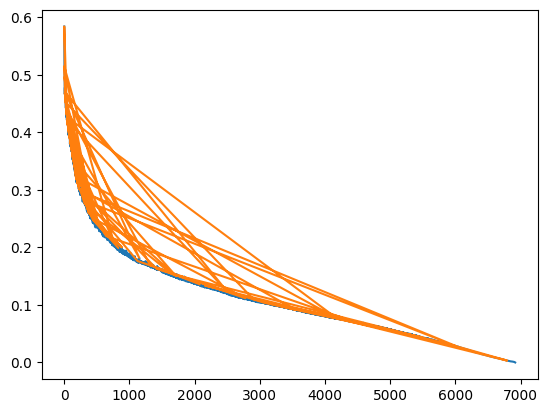

In [39]:
Y=df.iloc[:,-1]
plt.plot(Y)
Y_acquired=Y[acquired_mofs]
plt.plot(Y_acquired)

In [40]:
train_X=X.iloc[acquired_mofs].reset_index(drop=True)
train_Y=Y.iloc[acquired_mofs].reset_index(drop=True)
# Drop rows by their index values, reset the indices afterwards
test_X = X.drop(X.index[acquired_mofs]).reset_index(drop=True)
test_Y = Y.drop(Y.index[acquired_mofs]).reset_index(drop=True)
#test_X=X.drop(acquired_mofs)
#test_Y=Y.drop(acquired_mofs)

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [42]:
search_spaces = {
    'n_estimators': Integer(10, 1500),  # Range for n_estimators from 10 to 1000
    'max_features': Real(0.2, 1.0),      # Fraction of features to consider for best split
    'max_depth': Integer(1, 50),         # Maximum depth of the tree
    'min_samples_split': Integer(2, 20), # Minimum number of samples required to split an internal node
    'min_samples_leaf': Integer(1, 20),  # Minimum number of samples required to be at a leaf node
    #'bootstrap': [True, False]           # Whether bootstrap samples are used when building trees
}

In [43]:
rfr = RandomForestRegressor()

# BayesSearchCV
opt = BayesSearchCV(
    estimator=rfr,
    search_spaces=search_spaces,
    n_iter=50,  # Number of iterations for optimization
    cv=5,  # 5-fold cross-validation
    random_state=42,
    scoring='r2'
)

In [44]:
opt.fit(train_X,train_Y)

BayesSearchCV(cv=5, estimator=RandomForestRegressor(), random_state=42,
              scoring='r2',
              search_spaces={'max_depth': Integer(low=1, high=50, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.2, high=1.0, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=1500, prior='uniform', transform='normalize')})

In [45]:
best_model = opt.best_estimator_
y_pred = best_model.predict(test_X)
r2 = r2_score(test_Y, y_pred)
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.7058298462839492
